In [40]:
# Import necessary libraries
import pypsa
import matplotlib.pyplot as plt
import logging

from helpers import (
    plot_energy_balance,
    plot_capacity_comparison
)

logger = logging.getLogger("gurobipy")
logger.propagate = False

pypsa.__version__

'0.35.2'

In [56]:
network = pypsa.Network('/Users/kamrantehranchi/Local_Documents/energy310_notebooks/data/examples/elec_s380_c7a_ec_lv1.5_RPS-REM-TCT-1h_E.nc')
busmap = network.buses.interconnect
cols = ['Pd', 'country', 'reeds_zone']
[network.buses.drop(columns=col, inplace=True) for col in cols if col in network.buses.columns]
network = network.cluster.cluster_by_busmap(busmap)

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network '' has buses, carriers, generators, global_constraints, links, loads, storage_units


In [75]:
for component in network.components.keys():
    for attr in ["p_nom_extendable", "s_nom_extendable", "e_nom_extendable"]:
        if attr in network.df(component).columns:
            network.df(component)[attr] = False

It is often the case that we want to add custom constraints that provide functionality beyond the core functionality in the PyPSA package. These custom constraints vary widely based on your application. But lets look more closely at the linopy model to understand how we can add these custom constraints!

Lets' implement spinning reserves taken from [pypsa examples](https://pypsa.readthedocs.io/en/latest/examples/reserve-power.html#Implementing-spinning-reserve-constraints)

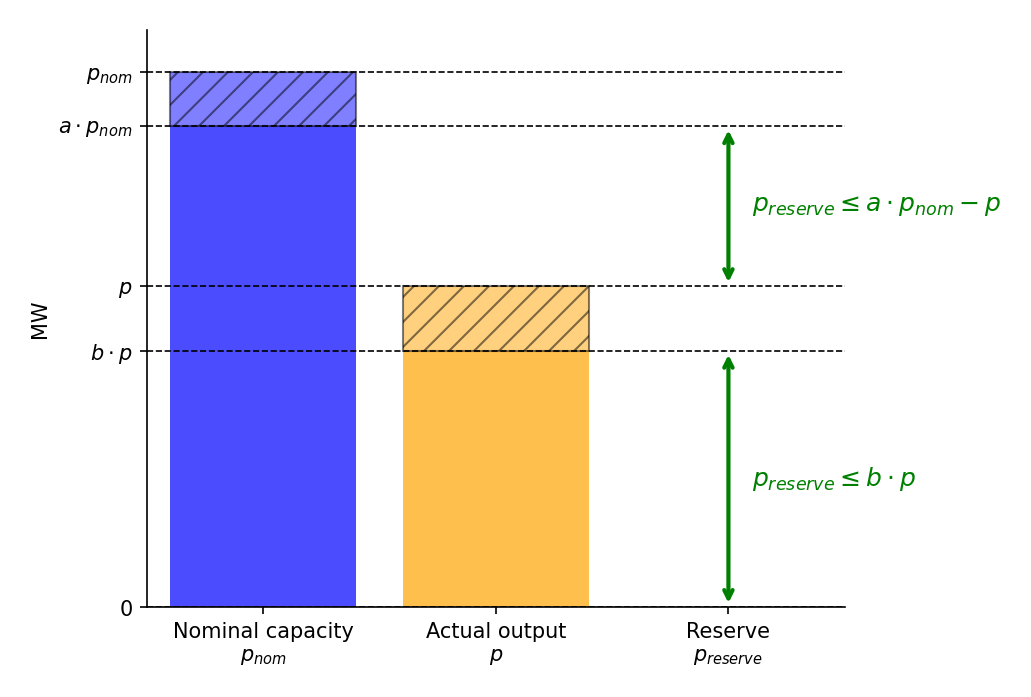

In [76]:
from IPython.display import Image, display

# Insert an image into the notebook
display(Image(filename='reserve-power-graph.webp'))


In [77]:
network.optimize(snapshots=network.snapshots[0:72], multi_investment_periods=True, solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 19.26it/s]
INFO:linopy.io: Writing time: 1.54s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-b5mkpwvg.lp
Reading time = 0.38 seconds
obj: 259154 rows, 99288 columns, 419877 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 259154 rows, 99288 columns and 419877 nonzeros
Model fingerprint: 0xa60a734e
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 5e+04]
Presolve removed 258578 rows and 95505 columns
Presolve time: 0.09s
Presolved: 576 rows, 3783 columns, 5295 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 99288 primals, 259154 duals
Objective: 4.39e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



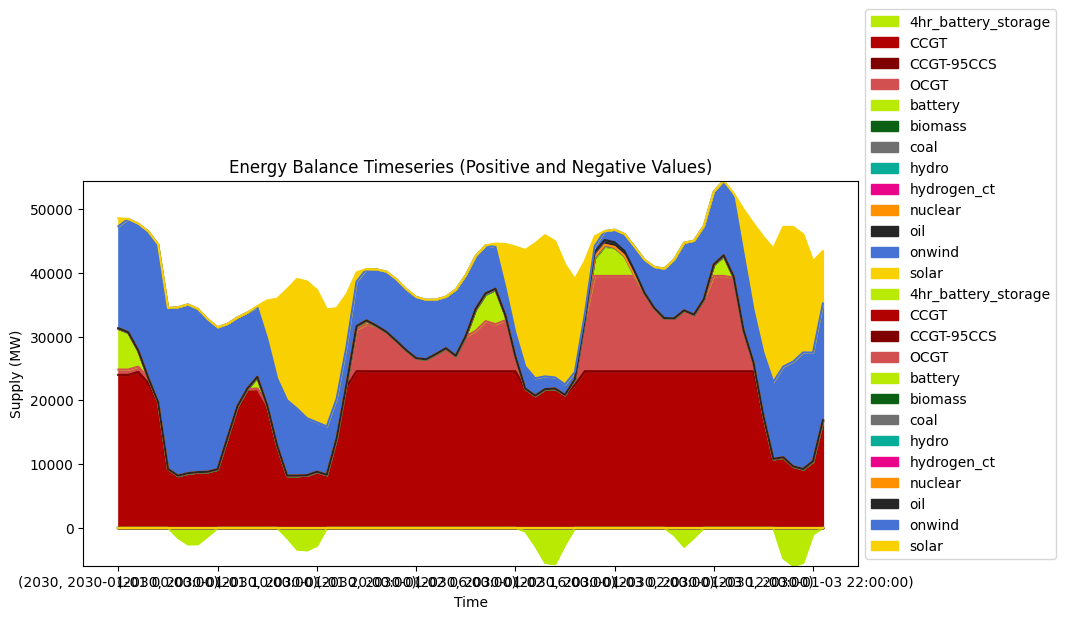

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Energy Balance Timeseries (Positive and Negative Values)'}, xlabel='Time', ylabel='Supply (MW)'>)

In [78]:
plot_energy_balance(network, 24 * 3)

In [119]:
network.optimize.create_model(snapshots=network.snapshots[0:72], multi_investment_periods=True)
model = network.model
model

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, period, timestep, Generator)
 * StorageUnit-p_dispatch (snapshot, period, timestep, StorageUnit)
 * StorageUnit-p_store (snapshot, period, timestep, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, period, timestep, StorageUnit)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-upper (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_up (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_down (snapshot, period, timestep, Generator-fix)
 * StorageUnit-fix-p_dispatch-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_dispatch-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-state_of_charge-lower (snapshot, perio

In [120]:
v_rp = network.model.add_variables(
    lower=0,
    coords=[network.model.variables['Generator-p'].coords['snapshot'], network.generators.index],
    name="Generator-p_reserve",
)
# model.variables['Generator-p'].coords
v_rp

Variable (snapshot (period, timestep): 72, Generator: 1355)
-----------------------------------------------------------
[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 0 oil]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 oil] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 0 onwind existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 onwind existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 0 solar existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 solar existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 1 onwind existing]: Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 1 onwind existing] ∈ [0, inf]
[(2030, 2030-01-01 00:00:00), p600 1 solar existing]: Generator-p_reserve[(2030,

In [121]:
# set reserve requirement as 3% of the maximum load
reserve_req = network.loads_t.p_set.iloc[0:72].max().max() * 0.1 #  req = ~475

c_sum = network.model.add_constraints(
    v_rp.sum("Generator") >= reserve_req, name="GlobalConstraint-sum_of_reserves"
)
c_sum

Constraint `GlobalConstraint-sum_of_reserves` [snapshot (period, timestep): 72]:
--------------------------------------------------------------------------------
[(2030, 2030-01-01 00:00:00)]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing] + 1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing] + 1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 oil] ... +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p64 hydrogen_ct_2030] + 1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p65 hydrogen_ct_2030] + 1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p67 hydrogen_ct_2030] ≥ 2112.19254
[(2030, 2030-01-01 01:00:00)]: +1 Generator-p_reserve[(2030, 2030-01-01 01:00:00), p600 0 CCGT existing] + 1 Generator-p_reserve[(2030, 2030-01-01 01:00:00), p600 0 OCGT existing] + 1 Generator-p_reserve[(2030, 2030-01-01 01:00:00), p600 0 oil] ... +1 Generator-p_reserve[(2030, 2030-01-01 01:00:00), p64 hydrogen_ct_2030] + 1 Generator-p_reserve[(2030

In [122]:
# Restrict the maximum reserve power that a generator can provide
a = 1
c_rpos = network.model.add_constraints(
    v_rp
    <= -network.model.variables["Generator-p"] + a * network.generators["p_nom"],
    name="Generator-reserve_upper_limit",
)
c_rpos

Constraint `Generator-reserve_upper_limit` [snapshot (period, timestep): 72, Generator: 1355]:
----------------------------------------------------------------------------------------------
[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing] + 1 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]       ≤ -0.0
[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing] + 1 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]       ≤ 1.2
[(2030, 2030-01-01 00:00:00), p600 0 oil]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 oil] + 1 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 oil]                                     ≤ 536.4
[(2030, 2030-01-01 00:00:00), p600 0 onwind existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 onwind existing] + 1 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 onwind

In [123]:
# Restrict the fraction of each generator's dispatch that can be used for reserves
b = 0.8

c_rneg = network.model.add_constraints(
    v_rp <= b * network.model.variables["Generator-p"],
    name="Generator-reserve_lower_limit",
)
c_rneg

Constraint `Generator-reserve_lower_limit` [snapshot (period, timestep): 72, Generator: 1355]:
----------------------------------------------------------------------------------------------
[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing] - 0.8 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 CCGT existing]       ≤ -0.0
[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing] - 0.8 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 OCGT existing]       ≤ -0.0
[(2030, 2030-01-01 00:00:00), p600 0 oil]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 oil] - 0.8 Generator-p[(2030, 2030-01-01 00:00:00), p600 0 oil]                                     ≤ -0.0
[(2030, 2030-01-01 00:00:00), p600 0 onwind existing]: +1 Generator-p_reserve[(2030, 2030-01-01 00:00:00), p600 0 onwind existing] - 0.8 Generator-p[(2030, 2030-01-01 00:00:00), p600 

In [124]:
model.constraints

linopy.model.Constraints
------------------------
 * Generator-fix-p-lower (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-upper (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_up (snapshot, period, timestep, Generator-fix)
 * Generator-fix-p-ramp_limit_down (snapshot, period, timestep, Generator-fix)
 * StorageUnit-fix-p_dispatch-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_dispatch-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-p_store-upper (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-state_of_charge-lower (snapshot, period, timestep, StorageUnit-fix)
 * StorageUnit-fix-state_of_charge-upper (snapshot, period, timestep, StorageUnit-fix)
 * Bus-nodal_balance (Bus, snapshot, period, timestep)
 * StorageUnit-energy_balance (snapshot, period, timestep, StorageUnit)
 * GlobalConstraint-sum_of_reserv

In [125]:
network.optimize.solve_model(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 13.45it/s]
INFO:linopy.io: Writing time: 3.25s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-grm6j4zj.lp
Reading time = 0.74 seconds
obj: 454346 rows, 196848 columns, 905085 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 454346 rows, 196848 columns and 905085 nonzeros
Model fingerprint: 0x0e43410c
Coefficient statistics:
  Matrix range     [8e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 5e+04]
Presolve removed 423817 rows and 165358 columns
Presolve time: 0.33s
Presolved: 30529 rows, 31490 columns, 92837 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 196848 primals, 454346 duals
Objective: 4.39e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, GlobalConstraint-sum_of_reserves, Generator-reserve_upper_limit, Generator-reserve_lower_limit were not assigned to the network.


('ok', 'optimal')

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



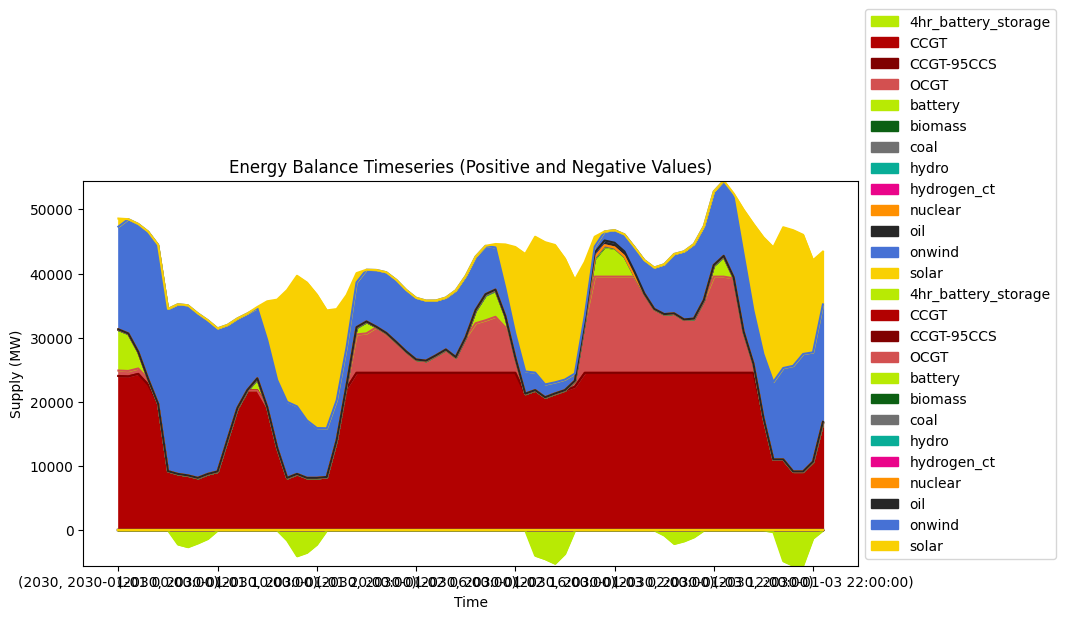

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Energy Balance Timeseries (Positive and Negative Values)'}, xlabel='Time', ylabel='Supply (MW)'>)

In [126]:
plot_energy_balance(network, 24 * 3)

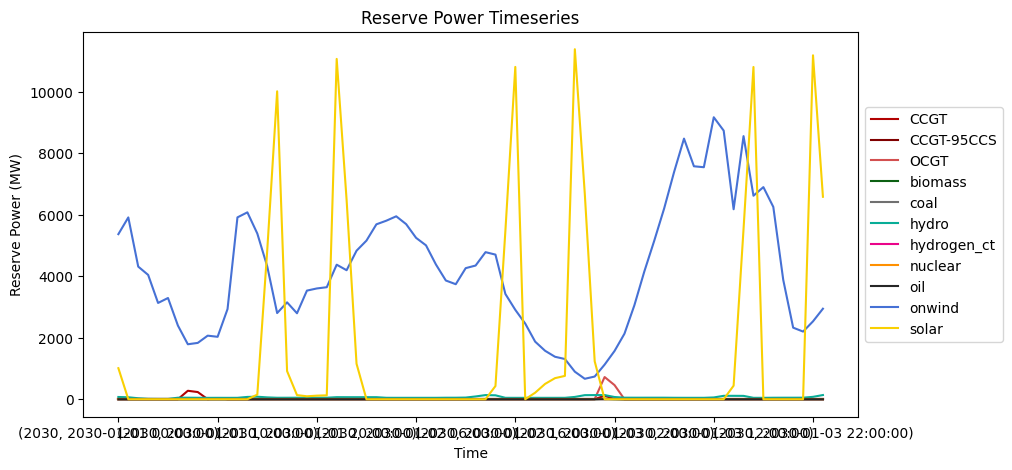

In [127]:
fig, ax = plt.subplots(figsize=(10, 5))
reserve_power = network.generators_t["p_reserve"].iloc[0:72].T
grouped_reserve_power = reserve_power.groupby(network.generators.carrier).sum().T

# Get colors for each carrier
colors = [network.carriers.loc[carrier, 'color'] for carrier in grouped_reserve_power.columns]

grouped_reserve_power.plot(ax=ax, color=colors)

ax.set_title("Reserve Power Timeseries")
ax.set_ylabel("Reserve Power (MW)")
ax.set_xlabel("Time")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


<Axes: xlabel='carrier'>

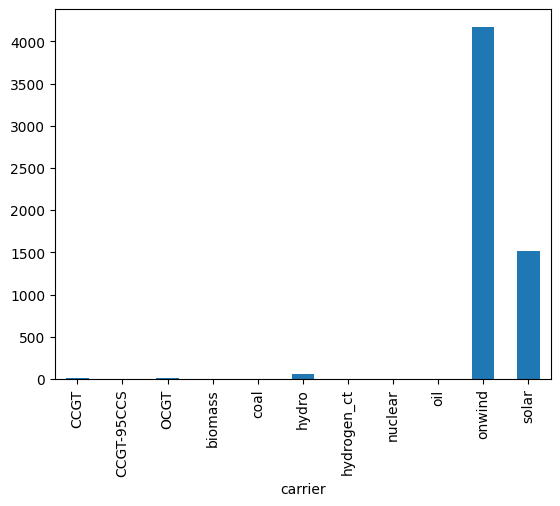

In [128]:
network.generators_t["p_reserve"].iloc[0:72].mean().groupby(network.generators.carrier).sum().plot(kind="bar")

In [129]:
network.generators_t["p_reserve"].iloc[0:72].sum(axis=1)

period  timestep           
2030    2030-01-01 00:00:00     6451.905925
        2030-01-01 01:00:00     5976.950202
        2030-01-01 02:00:00     4345.269817
        2030-01-01 03:00:00     4057.834223
        2030-01-01 04:00:00     3143.054565
                                   ...     
        2030-01-03 19:00:00     3932.742067
        2030-01-03 20:00:00     2377.145116
        2030-01-03 21:00:00     2250.447908
        2030-01-03 22:00:00    13798.308939
        2030-01-03 23:00:00     9665.452851
Length: 72, dtype: float64

In [130]:
network.statistics()

Optimal Capacity Installed Capacity  \
                                                    2030               2030   
Generator   Biomass                            137.00000          137.00000   
            Ccgt-95Ccs                               NaN                NaN   
            Coal                                     NaN                NaN   
            Combined-Cycle Gas               25038.45327        25038.45327   
            Hydrogen Combustion Turbine              NaN                NaN   
            Nuclear                                  NaN                NaN   
            Oil                                799.80000          799.80000   
            Onshore Wind                     34363.60000        34363.60000   
            Open-Cycle Gas                   16547.80000        16547.80000   
            Reservoir & Dam                    555.10000          555.10000   
            Solar                            30326.00000        30326.00000   
Load        Ac                                   0.00000            0.00000   
StorageUnit 4Hr_Battery_Storage                      NaN                NaN   
            Battery Storage                  10332.20000        10332.20000   

                                               Supply    Withdrawal  \
                                                 2030          2030   
Generator   Biomass                      6.838900e+02           NaN   
            Ccgt-95Ccs                            NaN           NaN   
            Coal                                  NaN           NaN   
            Combined-Cycle Gas           1.426127e+06           NaN   
            Hydrogen Combustion Turbine           NaN           NaN   
            Nuclear                               NaN           NaN   
            Oil                          3.856891e+03           NaN   
            Onshore Wind                 7.731835e+05           NaN   
            Open-Cycle Gas               2.932505e+05           NaN   
            Reservoir & Dam              5.408372e+03           NaN   
            Solar                        4.336083e+05           NaN   
Load        Ac                                    NaN  2.927219e+06   
StorageUnit 4Hr_Battery_Storage                   NaN           NaN   
            Battery Storage              5.043209e+04  5.933187e+04   

                                        Energy Balance Transmission  \
                                                  2030         0      
Generator   Biomass                       6.838900e+02          0.0   
            Ccgt-95Ccs                             NaN          0.0   
            Coal                                   NaN          0.0   
            Combined-Cycle Gas            1.426127e+06          0.0   
            Hydrogen Combustion Turbine            NaN          0.0   
            Nuclear                                NaN          0.0   
            Oil                           3.856891e+03          0.0   
            Onshore Wind                  7.731835e+05          0.0   
            Open-Cycle Gas                2.932505e+05          0.0   
            Reservoir & Dam               5.408372e+03          0.0   
            Solar                         4.336083e+05          0.0   
Load        Ac                           -2.927219e+06          0.0   
StorageUnit 4Hr_Battery_Storage                    NaN          0.0   
            Battery Storage              -8.899781e+03          0.0   

                                        Capacity Factor   Curtailment  \
                                                   2030          2030   
Generator   Biomass                            0.000570  1.076603e+06   
            Ccgt-95Ccs                              NaN           NaN   
            Coal                                    NaN           NaN   
            Combined-Cycle Gas                 0.006502  2.107451e+08   
            Hydrogen Combustion Turbine             NaN        